In [1]:
import numpy as np
import scipy.linalg as sl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_style('white')

from ipywidgets import interact


%load_ext autoreload
%autoreload 2
import bite_surface as bs

The model is a 8x8 matrix, with the top block being H12 and the bottom block being H32, linked by matrices Hint.

first, define the lattice vectors:

# Big model

In [14]:
a = 4.14
c = 28.70
a1 = a*np.array([1,0,0])
a2 = a*np.array([-1/2,np.sqrt(3)/2,0])
a3 = a*np.array([-1/2,-np.sqrt(3)/2,0])
b1 = np.array([0,np.sqrt(3)*a/3,c/3])
b2 = np.array([-a/2,-np.sqrt(3)*a/6,c/3])
b3 = np.array([a/2,-np.sqrt(3)*a/6,c/3])

Next, define the hopping constants and same-site energies

In [15]:
e1 = 0.805
e3 = -0.572
e5 = -0.9304
e7 = -1.900

t11a = -0.130
t33a = 0.120
t55a = 0.095
t77a = 0.171
t13a = 0.210
t14a = -0.270
t15a = 0.171
t17a = -0.140 + 1j*0.008
t35a = 0.092
t37a = 0.190
t57a = 0.009
t58a = 0.0005 # <10^-3

t11b = -0.027
t33b = 0.015
t55b = 0.007
t77b = -0.012
t13b = -0.025
t14b = 1j*0.210
t15b = 0.012
t17b = -0.012
t35b = -0.093
t37b = -0.110
t57b = 0.0005 # <10^-3
t58b = 0.012

In [16]:
# add hopping constant dependency later

def aii(kbar,tiia,tiib):
    part_a = 2*tiia*(np.cos(kbar@a1) + np.cos(kbar@a2) + np.cos(kbar@a3))
    part_b = 2*tiib*(np.cos(kbar@b1) + np.cos(kbar@b2) + np.cos(kbar@b3))
    return part_a + part_b

def a13(kbar):
    part_a = -1j*2*t13a*(np.sin(kbar@a1) + np.sin(kbar@a2) + np.sin(kbar@a3))
    part_b = 2*t13b*(np.sin(kbar@b1) + np.sin(kbar@b2) + np.sin(kbar@b3))
    return np.complex128(part_a + part_b)

def a14(kbar):
    part_a = 2*t14a*(np.sin(kbar@a1) + np.exp(-1j*2*np.pi/3)*np.sin(kbar@a2) + np.exp(-1j*4*np.pi/3)*np.sin(kbar@a3))
    part_b = 2*t14b*(np.exp(-1j*np.pi/2)*np.sin(kbar@b1) + np.exp(1j*5*np.pi/6)*np.sin(kbar@b2) + np.exp(1j*np.pi/6)*np.sin(kbar@b3))
    return part_a + part_b
    
def b57(kbar):
    return 2*t57b*(np.sin(kbar@b1) + np.sin(kbar@b2) + np.sin(kbar@b3))

def b58(kbar):
    return 2*t58a*(np.sin(kbar@a1) + np.sin(kbar@a2) + np.sin(kbar@a3))
    
def Phi(kbar,c):
    # c=0 corresponds to a and v-v
    if c==0:
        return np.sin(kbar@a1)-np.exp(-1j*np.pi/3)*np.sin(kbar@a2)+np.exp(-1j*2*np.pi/3)*np.sin(kbar@a3)
    elif c==1:
        return np.sin(kbar@b1)-np.exp(-1j*np.pi/3)*np.sin(kbar@b2)+np.exp(-1j*2*np.pi/3)*np.sin(kbar@b3)
    
def Psi(kbar,c):
    # c=0 corresponds to a and v-v
    if c==0:
        return np.cos(kbar@a1)-np.exp(-1j*np.pi/3)*np.cos(kbar@a2)+np.exp(-1j*2*np.pi/3)*np.cos(kbar@a3)
    elif c==1:
        return np.cos(kbar@b1)-np.exp(-1j*np.pi/3)*np.cos(kbar@b2)+np.exp(-1j*2*np.pi/3)*np.cos(kbar@b3)
    
def g15(kbar):
    mat = np.zeros((2,2),dtype=complex)
    ga = 2*t15a*Phi(kbar,c=0)
    gb = 2*t15b*Phi(kbar,c=1)
    
    mat[0,0] = ga + gb
    mat[0,1] = ga.conj() - gb.conj()
    mat[1,0] = -ga + gb
    mat[1,1] = ga.conj() + gb.conj()
    
    return 1j*mat
    

def g35(kbar):
    mat = np.zeros((2,2),dtype=complex)
    ga = 2*t35a*Psi(kbar,c=0)
    gb = 2*t35b*Psi(kbar,c=1)
    
    mat[0,0] = ga + gb
    mat[0,1] = -ga.conj() - gb.conj()
    mat[1,0] = ga + gb
    mat[1,1] = ga.conj() + gb.conj()
    
    return mat
    
def g17(kbar):
    mat = np.zeros((2,2),dtype=complex)
    ga = 2*t17a*Psi(kbar,c=0)
    gb = 2*t17b*Psi(kbar,c=1)
    
    mat[0,0] = ga + gb
    mat[0,1] = -ga.conj() - gb.conj()
    mat[1,0] = ga + gb
    mat[1,1] = ga.conj() + gb.conj()
    
    return mat
    
def g37(kbar):
    mat = np.zeros((2,2),dtype=complex)
    ga = 2*t37a*Phi(kbar,c=0)
    gb = 2*t37b*Phi(kbar,c=1)
    
    mat[0,0] = ga + gb
    mat[0,1] = ga.conj() - gb.conj()
    mat[1,0] = ga - gb
    mat[1,1] = ga.conj() + gb.conj()

    return 1j*mat
    

In [17]:
def H12(kx,ky,kz):
    
    kbar = np.array([kx,ky,kz])
        
    # make diagonals
    H12_diags = np.diag(np.array([e1+aii(kbar,t11a,t11b),e1+aii(kbar,t11a,t11b),e3+aii(kbar,t33a,t33b),e3+aii(kbar,t33a,t33b)]))
    
    # make off diagonals
    H12_offdiags = np.zeros((4,4),dtype=complex)
    H12_offdiags[0,2] = 1j*a13(kbar)
    H12_offdiags[0,3] = 1j*a14(kbar)
    H12_offdiags[1,2] = -1j*a14(kbar).conj()
    H12_offdiags[1,3] = 1j*a13(kbar).conj()
    
    H12 = H12_diags + H12_offdiags + H12_offdiags.conj().T
    
    return H12
def H32(kx,ky,kz):
    
    kbar = np.array([kx,ky,kz])

    # make diagonals
    H32_diags = np.diag(np.array([e5+aii(kbar,t55a,t55b),e5+aii(kbar,t55a,t55b),e7+aii(kbar,t77a,t77b),e7+aii(kbar,t77a,t77b)]))

    # make off-diagonals
    H32_offdiags = np.zeros((4,4),dtype=complex)
    H32_offdiags[0,2] = 1j*b57(kbar)
    H32_offdiags[0,3] = 1j*b58(kbar)
    H32_offdiags[1,2] = -1j*b58(kbar).conj()
    H32_offdiags[1,3] = 1j*b57(kbar).conj()
    
    H32 = H32_diags + H32_offdiags + H32_offdiags.conj().T
    
    return H32

def Hint(kx,ky,kz):
    
    kbar = np.array([kx,ky,kz])

    Hint = np.zeros((4,4),dtype=complex)
    Hint[0:2,0:2] = g15(kbar)
    Hint[0:2,2:4] = g17(kbar)
    Hint[2:4,0:2] = g35(kbar)
    Hint[2:4,2:4] = g37(kbar)
    
    return Hint
    
def Hbite(kx,ky,kz):
    """
    Hamiltonian for BiTe (8x8 bulk model)
    """
    ### top block diagonal
    
    H12_ = H12(kx,ky,kz)
    
    ### bottom block diagonal
    
    H32_ = H32(kx,ky,kz)
    
    ### H_int
    Hint_ = Hint(kx,ky,kz)
    
    H = sl.block_diag(H12_,H32_)
    H[0:4,4:8] = Hint_
    H[4:8,0:4] = Hint_.conj().T
    
    return H
    
def Hbite_mod(kx,ky,kz):
    """
    Hamiltonian for BiTe (8x8 bulk model)
    """
    kbar = np.array([kx,ky,kz])
    
    # make diagonals
    H12_diags = np.diag(np.array([e1+aii(kbar,t11a,t11b),e1+aii(kbar,t11a,t11b),e3+aii(kbar,t33a,t33b),e3+aii(kbar,t33a,t33b)]))
    
    # make off diagonals
    H12_offdiags = np.zeros((4,4),dtype=complex)
    H12_offdiags[0,2] = 1j*a13(kbar)
    H12_offdiags[0,3] = 1j*a14(kbar)
    H12_offdiags[1,2] = -1j*a14(kbar).conj()
    H12_offdiags[1,3] = 1j*a13(kbar).conj()
    
    H12 = H12_diags + H12_offdiags + H12_offdiags.conj().T
    
    return H12
    
    

In [18]:
def spectrum():
    res = 1000
    ks = np.linspace(-np.pi,np.pi,res)
    Es = np.zeros(8*res)
    
    for i,k in enumerate(ks):
        H = Hbite(k,0,0)
        E = np.linalg.eigvalsh(H)
        Es[i*8:(i+1)*8] = E
    
    ks_ret = np.repeat(ks,8)
    
    return ks_ret,Es

def spectrum_mod():
    res = 1000
    ks = np.linspace(-np.pi,np.pi,res)
    Es = np.zeros(4*res)
    
    for i,k in enumerate(ks):
        H = Hbite_mod(k,0,0)
        E = np.linalg.eigvalsh(H)
        Es[i*4:(i+1)*4] = E
    
    ks_ret = np.repeat(ks,4)
    
    return ks_ret,Es

In [19]:
ks,Es=spectrum()

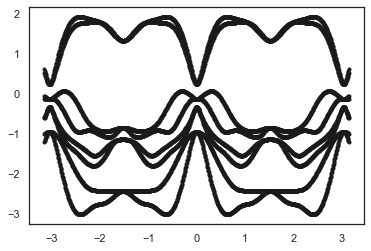

In [20]:
plt.scatter(ks,Es,c='k',marker='.')

# Effective model brute force

In [217]:
H = Hbite(kx=0,ky=0,kz=0)
E, w = np.linalg.eigh(H)

In [218]:
E

array([-0.946 , -0.946 , -0.3184, -0.3184, -0.137 , -0.137 ,  0.238 ,
        0.238 ])

In [72]:
w[:,4]

array([ 3.76491236e-01-0.00000000e+00j,  9.26277643e-01+1.62504850e-02j,
       -2.22044605e-16-2.77555756e-17j,  1.66533454e-16+3.89421535e-17j,
        9.86076132e-32+6.78441829e-33j, -5.71832013e-34+6.36991744e-34j,
       -9.54097912e-17-2.77555756e-16j, -3.98986399e-17-5.55111512e-17j])

In [71]:
w[:,5]

array([ 9.26420180e-01+0.00000000e+00j, -3.76433309e-01-6.60409315e-03j,
        5.55111512e-17+1.38777878e-17j, -6.93889390e-17-1.58258421e-17j,
       -4.93038066e-32-2.75714420e-33j,  2.32388872e-34-2.58869371e-34j,
        7.80625564e-18+2.64545330e-17j,  2.16840434e-17-5.42101086e-17j])

In [70]:
w[:,6]

array([ 0.00000000e+00+0.00000000e+00j,  1.06102053e-16-1.06102053e-17j,
        4.53486713e-02-1.18340282e-01j, -8.91324367e-01-4.35292945e-01j,
        0.00000000e+00+1.10899625e-16j, -1.10899625e-16+5.76510410e-17j,
        3.25322948e-17-5.18998595e-17j, -6.01651939e-17+1.14932618e-17j])

In [69]:
w[:,7]

array([ 0.00000000e+00+0.00000000e+00j,  1.54078634e-16-1.47620248e-17j,
        9.64596755e-01+2.31283757e-01j, -4.03082417e-02+1.20150613e-01j,
       -2.22044605e-16-1.40814106e-17j,  1.11225925e-16+3.23356599e-17j,
       -2.53480478e-17+9.85859644e-17j,  8.94772286e-17-4.85339209e-17j])

In [111]:
ks_mod, Es_mod = spectrum_mod()

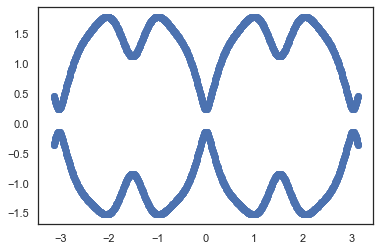

In [112]:
plt.scatter(ks_mod, Es_mod)

In [89]:
psis_gamma = np.array([w[:,4],w[:,5],w[:,6],w[:,7]])

In [96]:
def Heff(psis,kx,ky,kz):
    # effective subspace
    n = psis.shape[0]
    # initialize Heff
    He = np.zeros((n,n),dtype=complex)
    # define 8x8 H
    H = Hbite(kx,ky,kz)
    # effective H is a projection onto these states
    for i in range(n):
        for j in range(n):
            He[i,j] = psis[i].conj().T @ H @ psis[j]
            
    return He

def spectrum_effective(psis):
    res = 1000
    ks = np.linspace(-np.pi,np.pi,res)
    Es = np.zeros(4*res)
    
    for i,k in enumerate(ks):
        H = Heff(psis,k,0,0)
        E = np.linalg.eigvalsh(H)
        Es[i*4:(i+1)*4] = E
    
    ks_ret = np.repeat(ks,4)
    
    return ks_ret,Es

In [100]:
ks_eff, Es_eff = spectrum_mod()

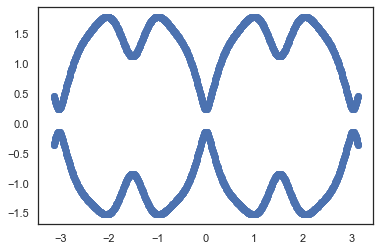

In [101]:
plt.scatter(ks_eff,Es_eff)

In [113]:
Es_eff-Es_mod

array([0., 0., 0., ..., 0., 0., 0.])

In [219]:
H = Hbite(kx=0.5,ky=0,kz=0) # a bit away from Gamma
E, w = np.linalg.eigh(H)

In [220]:
E

array([-2.89198809, -1.85278418, -1.40433403, -1.19726608, -0.88017106,
       -0.10714986,  1.68093015,  1.87587277])

In [221]:
w[:,4]

array([-0.22735911+0.j        , -0.13923692-0.0947986j ,
        0.3200791 -0.2943881j ,  0.02799947+0.49000472j,
        0.63875782+0.05527145j, -0.24988947-0.08655849j,
       -0.07059989-0.00406788j,  0.0626449 +0.00129541j])

In [222]:
w[:,5]

array([ 0.40589098+0.j        ,  0.05347171-0.25017246j,
        0.4174769 -0.16691141j,  0.19163466-0.31091587j,
       -0.00213922-0.12671028j, -0.10718372-0.32501985j,
       -0.15943984-0.30703931j, -0.29402626-0.30811712j])

In [223]:
w[:,6]

array([ 0.30409641+0.j        , -0.70047051+0.20407765j,
        0.28295449+0.30805969j, -0.21745342+0.19273685j,
       -0.06183382-0.29293733j,  0.11848809+0.10475431j,
        0.0169793 -0.00966453j, -0.02794003-0.00321212j])

In [224]:
w[:,7]

array([-0.67005739+0.j        , -0.27486836+0.05073969j,
        0.32126488+0.1094573j ,  0.20854424-0.40718429j,
       -0.07802888+0.11888779j,  0.01754485+0.26197064j,
       -0.13321656-0.14308251j, -0.03518093-0.14070533j])

In [308]:
def Geff(w,kx,ky,kz):
    # k-vector
    kbar = np.array([kx,ky,kz])
    
    ### top block diagonal
    
    # make diagonals
    H12_diags = np.diag(np.array([e1+aii(kbar,t11a,t11b),e1+aii(kbar,t11a,t11b),e3+aii(kbar,t33a,t33b),e3+aii(kbar,t33a,t33b)]))
    
    # make off diagonals
    H12_offdiags = np.zeros((4,4),dtype=complex)
    H12_offdiags[0,2] = 1j*a13(kbar)
    H12_offdiags[0,3] = 1j*a14(kbar)
    H12_offdiags[1,2] = -1j*a14(kbar).conj()
    H12_offdiags[1,3] = 1j*a13(kbar).conj()
    
    H12 = H12_diags + H12_offdiags + H12_offdiags.conj().T
    
    ### bottom block diagonal
    
    # make diagonals
    H32_diags = np.diag(np.array([e5+aii(kbar,t55a,t55b),e5+aii(kbar,t55a,t55b),e7+aii(kbar,t77a,t77b),e7+aii(kbar,t77a,t77b)]))

    # make off-diagonals
    H32_offdiags = np.zeros((4,4),dtype=complex)
    H32_offdiags[0,2] = 1j*b57(kbar)
    H32_offdiags[0,3] = 1j*b58(kbar)
    H32_offdiags[1,2] = -1j*b58(kbar).conj()
    H32_offdiags[1,3] = 1j*b57(kbar).conj()
    
    H32 = H32_diags + H32_offdiags + H32_offdiags.conj().T
    
    ### H_int
    Hint = np.zeros((4,4),dtype=complex)
    Hint[0:2,0:2] = g15(kbar)
    Hint[0:2,2:4] = g17(kbar)
    Hint[2:4,0:2] = g35(kbar)
    Hint[2:4,2:4] = g37(kbar)
    
    delta = 0.15
    G32 = np.linalg.inv(w+1j*delta - H32)
    Ginv = (w+1j*delta)*np.eye(4) - H12 - Hint.conj().T @ G32 @ Hint
    G = np.linalg.inv(Ginv)
    
#     G = np.linalg.inv((w+1j*delta)*np.eye(8) - Hbite(kx,ky,kz))
    
    return G

def spectral_function(ky,kz):
    res = 100
    A = np.zeros((res,res),dtype=float)
    
    kxs = np.linspace(-1.5,1.5,res)
    ws = np.linspace(-1.5,1.5,res)
    
    for i,w in enumerate(ws):
        for j,kx in enumerate(kxs):
            G = Geff(w,kx,ky,kz)
            A[i,j] = -1/np.pi*np.imag(np.trace(G))
            
    return A

def Heff(kx,ky,kz):
    # k-vector
    kbar = np.array([kx,ky,kz])
    
    ### top block diagonal
    
    # make diagonals
    H12_diags = np.diag(np.array([e1+aii(kbar,t11a,t11b),e1+aii(kbar,t11a,t11b),e3+aii(kbar,t33a,t33b),e3+aii(kbar,t33a,t33b)]))
    
    # make off diagonals
    H12_offdiags = np.zeros((4,4),dtype=complex)
    H12_offdiags[0,2] = 1j*a13(kbar)
    H12_offdiags[0,3] = 1j*a14(kbar)
    H12_offdiags[1,2] = -1j*a14(kbar).conj()
    H12_offdiags[1,3] = 1j*a13(kbar).conj()
    
    H12 = H12_diags + H12_offdiags + H12_offdiags.conj().T
    
    ### bottom block diagonal
    
    # make diagonals
    H32_diags = np.diag(np.array([e5+aii(kbar,t55a,t55b),e5+aii(kbar,t55a,t55b),e7+aii(kbar,t77a,t77b),e7+aii(kbar,t77a,t77b)]))

    # make off-diagonals
    H32_offdiags = np.zeros((4,4),dtype=complex)
    H32_offdiags[0,2] = 1j*b57(kbar)
    H32_offdiags[0,3] = 1j*b58(kbar)
    H32_offdiags[1,2] = -1j*b58(kbar).conj()
    H32_offdiags[1,3] = 1j*b57(kbar).conj()
    
    H32 = H32_diags + H32_offdiags + H32_offdiags.conj().T
    
    ### H_int
    Hint = np.zeros((4,4),dtype=complex)
    Hint[0:2,0:2] = g15(kbar)
    Hint[0:2,2:4] = g17(kbar)
    Hint[2:4,0:2] = g35(kbar)
    Hint[2:4,2:4] = g37(kbar)
    
    G32 = np.linalg.inv(0 - H32) # w = 0 for low-energy shenanigans
    H = H12 + Hint.conj().T @ G32 @ Hint
    
    return H

def spectrum_effective(ky,kz):
    res = 1000
    ks = np.linspace(-np.pi,np.pi,res)
    Es = np.zeros(4*res,dtype=float)
    
    for i,k in enumerate(ks):
        H = Heff(k,0,0)
        E = np.linalg.eigvalsh(H)
        Es[i*4:(i+1)*4] = E
    
    ks_ret = np.repeat(ks,4)
    
    return ks_ret,Es
    

In [161]:
A=spectral_function(0,0)

(0.0, 99.0)

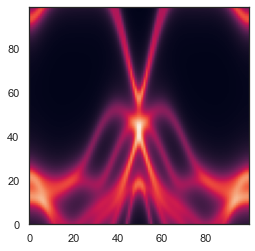

In [159]:
plt.imshow(A)
plt.ylim(0,99)

(0.0, 99.0)

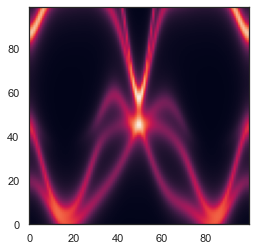

In [162]:
plt.imshow(A)
plt.ylim(0,99)

In [309]:
ks_eff,Es_eff=spectrum_effective(0,0)

(-1.0, 1.0)

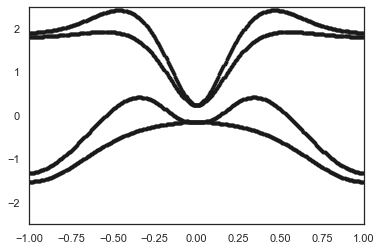

In [311]:
plt.scatter(ks_eff,Es_eff,c='k',marker='.')
plt.ylim(-2.5,2.5)
plt.xlim(-1,1)

# Effective models analytic

In [6]:
# 4x4 from linearizing and using T.H.T trick
# only along kx
def Heff2(kx,e1,e3,a,b,c,d,a1,a2,a3,a4,a5,a6,a7):
    # diags
    H = np.diag([e1+a*kx**2+b*kx**4,e1+a*kx**2+b*kx**4,e3+c*kx**2+d*kx**4,e3+c*kx**2+d*kx**4])
    H = H.astype(complex)
    
    # off diags in lower block
    H[3,2] = a6*kx**2-a7*kx**3
    H[2,3] = a6*kx**2-a7*kx**3
    
    # off diags
    Hint = np.zeros((2,2),dtype=complex)
    Hint[0,0] = a1*kx**3
    Hint[1,1] = -a5*kx**3
    Hint[0,1] = a2.conj()*kx-a4*kx**3
    Hint[1,0] = a2*kx-a3*kx**3
    
    H[2:,:2] = Hint
    H[:2,2:] = Hint.conj().T
    
    return H

def spectrum_eff(e1,e3,a,b,c,d,a1,a2,a3,a4,a5,a6,a7):
    res = 1000
    ks = np.linspace(-1,1,res)
    Es = np.zeros(4*res)
    
    for i,k in enumerate(ks):
        H = Heff2(k,e1,e3,a,b,c,d,a1,a2,a3,a4,a5,a6,a7)
        E = np.linalg.eigvalsh(H)
        Es[i*4:(i+1)*4] = E
    
    ks_ret = np.repeat(ks,4)
    
    return ks_ret,Es

In [7]:
@interact(e1=(-0.3,0.3,0.01),e3=(-0.3,0.3,0.01),a=(-50,50,0.1),b=(-50,50,0.1),c=(-50,50,0.1),d=(-50,50,0.1),
          a1=(0,10,0.1),a1_=(-np.pi,np.pi,0.1),a2=(0,10,0.1),a2_=(-np.pi,np.pi,0.1),a3=(0,10,0.1),
          a3_=(-np.pi,np.pi,0.1),a4=(0,10,0.1),a4_=(-np.pi,np.pi,0.1),a5=(0,10,0.1),a5_=(-np.pi,np.pi,0.1),
          a6=(0,10,0.1),a7=(0,10,0.1))
def Spectrum(e1=-0.137,e3=0.238,a=30,b=0,c=1.2,d=0,a1=10,a1_=np.pi/2,a2=5,a2_=np.pi/2,
             a3=10,a3_=np.pi/2,a4=10,a4_=np.pi/2,a5=5,a5_=np.pi/2,a6=0,a7=0):
    
    a1 = a1*np.exp(1j*a1_)
    a2 = a2*np.exp(1j*a2_)
    a3 = a3*np.exp(1j*a3_)
    a4 = a4*np.exp(1j*a4_)
    a5 = a5*np.exp(1j*a5_)

    ks,Es=spectrum_eff(e1,e3,a,b,c,d,a1,a2,a3,a4,a5,a6,a7)
    plt.scatter(ks,Es,c='k',marker='.',alpha=0.01)
    plt.ylim(-2,2)

interactive(children=(FloatSlider(value=-0.137, description='e1', max=0.3, min=-0.3, step=0.01), FloatSlider(v…

In [8]:
@interact(m=(-2,2,0.1),a=(-10,10,0.1),v=(-15,5,0.1),b=(-10,50,0.1))
def Spectrum(m=0.2,a=5,v=3,b=8):
    ks,Es=spectrum_eff(m,a,v,b)
    plt.scatter(ks,Es,c='k',marker='.',alpha=0.01)
    plt.ylim(-2,2)

interactive(children=(FloatSlider(value=0.2, description='m', max=2.0, min=-2.0), FloatSlider(value=5.0, descr…

In [9]:
ks,es,ps=bs.spectrum_eff_open(size=10,m=0.2,a=3,v=2,b=15)

(-2.0, 2.0)

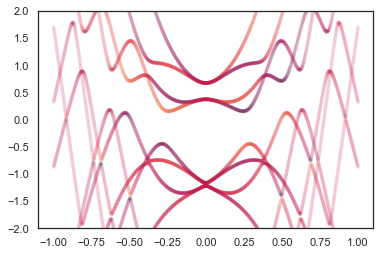

In [10]:
plt.scatter(ks,es,alpha=0.1,marker='.',c=ps)
plt.ylim(-2,2)

In [13]:
# first order perutrbation theory

# diagonalize H12
res=100
kxs=np.linspace(-1,1,res)
E0s=np.zeros((4,res),dtype=complex)
Es=np.zeros((4,res),dtype=complex)
ky=0
kz=0

for i in range(res):
    kx=kxs[i]
    H0 = H12(kx,ky,kz)
    E0, W0s = np.linalg.eigh(H0)

    # define H1
    H1 = -Hint(kx,ky,kz).conj().T @ np.linalg.inv(H32(kx,ky,kz)) @ Hint(kx,ky,kz)

    # Es
    for j in range(4):
        Es[j,i] = W0s[:,j].conj().T @ H1 @ W0s[:,j] + E0[j]
        
    E0s[:,i] = E0

NameError: name 'H12' is not defined

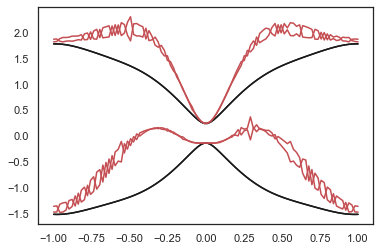

In [392]:
plt.plot(kxs,np.real(E0s).T,c='k')
plt.plot(kxs,np.real(Es).T,c='r')
plt.show()

In [301]:
W0s[:,3].conj().T @ H1 @ W0s[:,0]

0j

# Naive model

In [11]:
# simpler model
def Hsimple(kx,ky,v,a,b,m):
    s0 = np.array([[1,0],[0,1]])
    s1 = np.array([[0,1],[1,0]])
    s2 = np.array([[0,-1j],[1j,0]])
    s3 = np.array([[1,0],[0,-1]])
    
    return v*(kx*s2-ky*s1) + a*(kx**2 + ky**2)*s0 +b*(m-kx**2-ky**2)*s3 # add momentum dependence
    
def Hbite_bulk(kx,ky,v,a,b,m):
    s0 = np.array([[1,0],[0,1]])
    s1 = np.array([[0,1],[1,0]])
    s2 = np.array([[0,-1j],[1j,0]])
    s3 = np.array([[1,0],[0,-1]])
    
    H = v*(np.sin(kx)*s2-np.sin(ky)*s1) + a*(2-2*np.cos(kx)+2-2*np.cos(ky))*s0 + b*(m-2+2*np.cos(kx)-2+2*np.cos(ky))*s3
    
    return H

def spectrum_simple(a,b,m):
    res = 1000
    ks = np.linspace(-np.pi,np.pi,res)
    Es = np.zeros(2*res)
    
    for i,k in enumerate(ks):
        H = Hbite_bulk(k,0,v=1,a=a,b=b,m=m)
        E = np.linalg.eigvalsh(H)
        Es[i*2:(i+1)*2] = E
    
    ks_ret = np.repeat(ks,2)
    
    return ks_ret,Es



In [12]:
ks_simple, Es_simple = spectrum_simple(0.5,0.5,0.3)

In [13]:
@interact(a=(0,4,0.1),b=(0,4,0.1),m=(0,4,0.1))
def Spectrum(a=1,b=1,m=1):
    ks,es = spectrum_simple(a,b,m)
    plt.scatter(ks,es,c='k',marker='.')
    plt.ylim(-2,2)


interactive(children=(FloatSlider(value=1.0, description='a', max=4.0), FloatSlider(value=1.0, description='b'…

In [14]:
def Hbite_open(size,kx,v,a,b,m):
    s0 = np.array([[1,0],[0,1]])
    s1 = np.array([[0,1],[1,0]])
    s2 = np.array([[0,-1j],[1j,0]])
    s3 = np.array([[1,0],[0,-1]])
    
    # diagonals
    diags_0 = np.asarray([4*a - 2*a*np.cos(kx) for _ in range(size)])
    diags_y = np.asarray([v * np.sin(kx) for _ in range(size)])
    diags_z = np.asarray([b*(m-4+2*np.cos(kx)) for _ in range(size)])

    diag_0 = np.kron(np.diag(diags_0),s0)
    diag_y = np.kron(np.diag(diags_y),s2)
    diag_z = np.kron(np.diag(diags_z),s3)

    diags = diag_0 + diag_y + diag_z

    # hopping
    hop_low = -1j * v / 2 * np.kron(np.eye(size,k=-1),s1) + b * np.kron(np.eye(size,k=-1),s3) - a * np.kron(np.eye(size,k=-1),s0)
    hop = hop_low + hop_low.conj().T

    MAT = diags + hop

    return MAT


def spectrum_open(size,a,b,m):
    res = 1000
    ks = np.linspace(-np.pi,np.pi,res)
    Es = np.zeros(2*res*size)
    
    for i,k in enumerate(ks):
        H = Hbite_open(size,kx=k,v=1,a=a,b=b,m=m)
        E = np.linalg.eigvalsh(H)
        Es[i*2*size:(i+1)*2*size] = E
    
    ks_ret = np.repeat(ks,2*size)
    
    return ks_ret,Es

In [15]:
ks_open,Es_open=spectrum_open(size=10,a=0.9,b=1.3,m=0.4)
ks_simple, Es_simple = spectrum_simple(a=0.9,b=1.3,m=0.4)

In [16]:
@interact(a=(0,4,0.1),b=(0,4,0.1),m=(0,4,0.1))
def Spectrum(a=0.5,b=1,m=1):
    ks_open,Es_open=spectrum_open(size=50,a=a,b=b,m=m)
    ks_simple, Es_simple = spectrum_simple(a=a,b=b,m=m)
    plt.scatter(ks_open,Es_open,c='k',marker='.',alpha=0.01)
    plt.scatter(ks_simple,Es_simple,c='r',marker='.')
    plt.ylim(-2,2)

interactive(children=(FloatSlider(value=0.5, description='a', max=4.0), FloatSlider(value=1.0, description='b'…

(-1.0, 1.0)

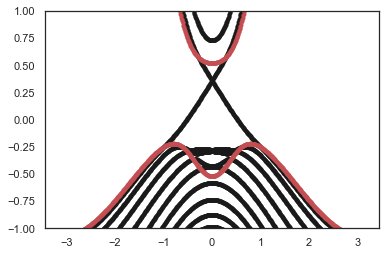

In [17]:
plt.scatter(ks_open,Es_open,c='k',marker='.')
plt.scatter(ks_simple,Es_simple,c='r',marker='.')
plt.ylim(-1,1)

# 3DTI BiTe model from Qi and Zhang

## Tunable

In [7]:
ks,es=bs.spectrum_3DTI(ky=0,kz=0,A1=1,B1=1,A2=1,B2=1,C=1,D1=1,D2=1,M=1)

In [15]:
@interact(ky=(-1.5,1.5,0.1),kz=(-1.5,1.5,0.1),A1=(-5,5,0.1),B1=(-5,5,0.1),A2=(-5,5,0.1),B2=(-5,5,0.1),D1=(-5,5,0.1),D2=(-5,5,0.1),M=(-5,5,0.1))
def Spectrum(ky=0,kz=0,A1=1,B1=1,A2=1,B2=2,C=0,D1=1,D2=1.3,M=0.5):
    ks,es=bs.spectrum_3DTI(ky=ky,kz=kz,A1=A1,B1=B1,A2=A2,B2=B2,C=C,D1=D1,D2=D2,M=M)
    plt.scatter(ks,es,c='k',marker='.',alpha=0.01)
    plt.xlim(-1.5,1.5)
    plt.ylim(-1.5,1.5)
    plt.show()

interactive(children=(FloatSlider(value=0.0, description='ky', max=1.5, min=-1.5), FloatSlider(value=0.0, desc…

## Bulk 4-band

In [632]:
ks_bulk,es_bulk=bs.spectrum_3DTI(ky=0,kz=0,A1=2.26,B1=6.86,A2=3.33,B2=44.5,C=0,D1=5.74,D2=30.4,M=-0.50,R1=50.6,R2=-113.3)


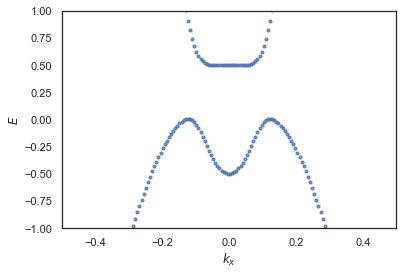

In [633]:
plt.scatter(ks_bulk,es_bulk,c='b',alpha=0.5,marker='.')
# plt.scatter(ks_surf,es_surf,c='k',marker='.',alpha=0.5)

plt.ylim(-1,1)
plt.xlim(-0.5,0.5)
plt.xlabel(r"$k_x$")
plt.ylabel(r"$E$")
plt.show()

Spectral function

In [480]:
As=bs.spectral_function_plot_bulk(ky=0,kz=0,A1=2.26,B1=6.86,A2=3.33,B2=44.5,C=0,D1=5.74,D2=30.4,M=-0.50,R1=50.6,R2=-113.3,side=0)

(0.0, 99.0)

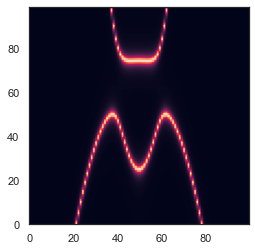

In [481]:
plt.imshow(As)
plt.ylim(0,99)

## Open (+ surface theory overlayed)

In [657]:
size = 200
# ks,es,pos=bs.spectrum_3DTI_open(size=100,ky=0,A1=0.30,B1=2.79,A2=2.87,B2=57.38,C=-0.18,D1=6.55,D2=49.68,M=-0.30,R1=45.02*0,R2=-89.37*0)
ks,es,pos=bs.spectrum_3DTI_open(size=size,ky=0,A1=2.26,B1=6.86,A2=3.33,B2=44.5,C=0,D1=5.74,D2=30.4,M=-1.0,R1=50.6,R2=-113.3)








In [658]:
# ks_surf,es_surf=bs.spectrum_3DTI_surface(ky=0,A1=0.30,B1=2.79,A2=2.87,B2=57.38,C=-0.18,D1=6.55,D2=49.68,M=-0.30,R1=45.02*0,R2=-89.37*0)
ks_surf,es_surf=bs.spectrum_3DTI_surface(ky=0,A1=2.26,B1=6.86,A2=3.33,B2=44.5,C=0,D1=5.74,D2=30.4,M=-0.50,R1=50.6,R2=-113.3)





In [667]:
ks_right = ks[pos>170]
ks_left = ks[pos<30]

es_right = es[pos>170]
es_left = es[pos<30]

ks_bulk = ks[np.logical_and(pos<=170,pos>=30)]
es_bulk = es[np.logical_and(pos<=170,pos>=30)]

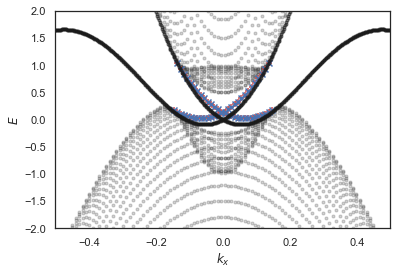

In [670]:
plt.scatter(ks_bulk,es_bulk,c='k',marker='.',alpha=0.1)

plt.scatter(ks_left,es_left,c='r',marker='+',alpha=1)
plt.scatter(ks_right,es_right,c='b',marker='x',alpha=1)



plt.scatter(ks_surf,es_surf,c='k',marker='.',alpha=0.5)

plt.xlabel(r"$k_x$")
plt.ylabel(r"$E$")

plt.ylim(-2,2)
plt.xlim(-0.5,0.5)
# plt.colorbar()
plt.show()

## Interface plots:

### Full system

In [593]:
# to compare both Green function plots and spectra
def CoordToRes(x,res,krange):
    # converts points to be able to plot them imshow
    res = res-1
    return res / (2 * krange) * np.asarray(x) + res / 2

In [634]:
As = bs.spectral_function_plot_open(size=100,res=30,w_range=1,ky=0,A1=2.26,B1=6.86,A2=3.33,B2=44.5,C=0,D1=5.74,D2=30.4,M=-1.00,R1=50.6,R2=-113.3,side=0)



(0.0, 29.0)

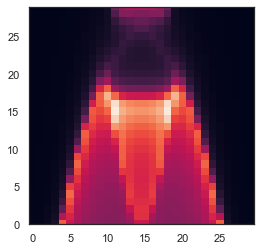

In [635]:
plt.imshow(As)
plt.ylim(0,29)

In [591]:
As_cluster=np.loadtxt("spectral_function_open.csv", delimiter=',')

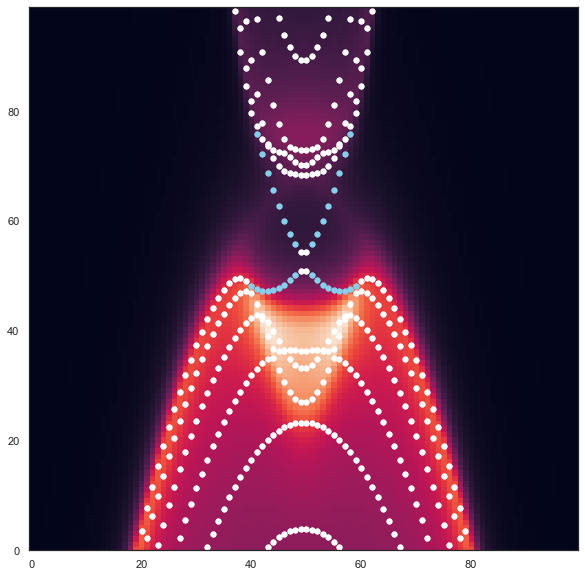

In [602]:
plt.figure(figsize=(10,10))

plt.imshow(As_cluster)
plt.ylim(0,99)

plt.scatter(CoordToRes(ks_bulk,100,0.5),CoordToRes(es_bulk,100,1),c='white',marker='.',s=100)
plt.scatter(CoordToRes(ks_left,100,0.5),CoordToRes(es_left,100,1),c='skyblue',marker='.',s=100)
plt.scatter(CoordToRes(ks_right,100,0.5),CoordToRes(es_right,100,1),c='skyblue',marker='.',s=100)

In [604]:
As_cluster=np.loadtxt("spectral_function_open.csv", delimiter=',')

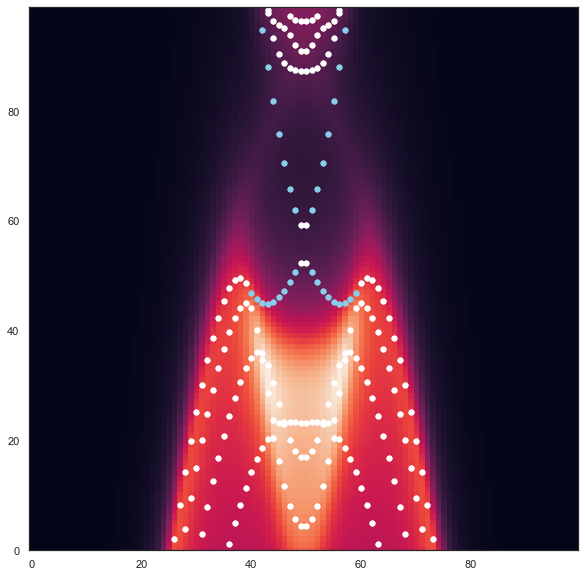

In [606]:
plt.figure(figsize=(10,10))

plt.imshow(As_cluster)
plt.ylim(0,99)

plt.scatter(CoordToRes(ks_bulk,100,0.5),CoordToRes(es_bulk,100,0.5),c='white',marker='.',s=100)
plt.scatter(CoordToRes(ks_left,100,0.5),CoordToRes(es_left,100,0.5),c='skyblue',marker='.',s=100)
plt.scatter(CoordToRes(ks_right,100,0.5),CoordToRes(es_right,100,0.5),c='skyblue',marker='.',s=100)

### Left side

In [383]:
As = bs.spectral_function_plot_open(size=30,ky=0,A1=2.26,B1=6.86,A2=3.33,B2=44.5,C=0,D1=5.74,D2=30.4,M=-0.50,R1=50.6,R2=-113.3,side=-1)


(0.0, 99.0)

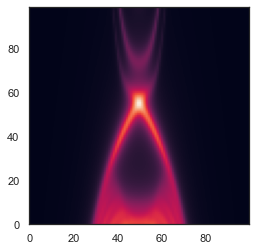

In [384]:
plt.imshow(As)
plt.ylim(0,99)

Spin-polarized:

### Right side

In [385]:
As = bs.spectral_function_plot_open(size=30,ky=0,A1=2.26,B1=6.86,A2=3.33,B2=44.5,C=0,D1=5.74,D2=30.4,M=-0.50,R1=50.6,R2=-113.3,side=+1)


(0.0, 99.0)

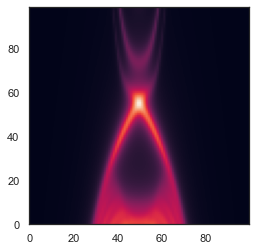

In [386]:
plt.imshow(As)
plt.ylim(0,99)

In [445]:
# tau = +1
As = bs.spectral_function_plot_open(size=30,ky=0,A1=2.26,B1=6.86,A2=3.33,B2=44.5,C=0,D1=5.74,D2=30.4,M=-0.50,R1=50.6,R2=-113.3,side=+1)


(0.0, 29.0)

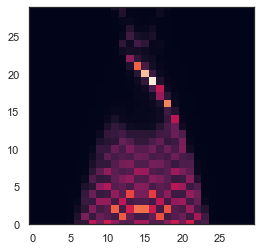

In [446]:
plt.imshow(As)
plt.ylim(0,29)

In [455]:
# tau = -1
As = bs.spectral_function_plot_open(size=30,ky=0,A1=2.26,B1=6.86,A2=3.33,B2=44.5,C=0,D1=5.74,D2=30.4,M=-0.50,R1=50.6,R2=-113.3,side=+1)


(0.0, 29.0)

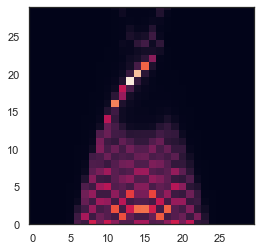

In [456]:
plt.imshow(As)
plt.ylim(0,29)